# Logistic Regression

逻辑回归模型是一种常用的分类模型，它通过sigmoid或者softmax函数，将函数值映射到(0, 1)区间内，从而实现对样本的分类。在这个小作业中，你需要实现：
1. 二分类和多分类两种逻辑回归模型
2. 分别含有 L1 和 L2 两种正则项的损失函数，并计算对应的梯度
3. 权重参数W的更新
4. 比较不同的学习率对损失函数和分类器性能的影响
5. 比较不同的正则项参数对于分类器性能的影响
   
**本次小作业截止时间：3.22, 请在canvas系统中及时提交。**

以下内容节选自《动手学机器学习》

# 逻辑斯谛回归

在介绍了机器学习中相关的基本概念和技巧后，本章我们继续讲解参数化模型中的线性模型。在线性回归中，我们利用参数化的线性假设解决了回归问题，而分类问题作为机器学习任务中的另一大类别，其与回归问题既有相似也有不同。通常来说，回归问题的输出是连续的，而分类问题的输出是离散的。

设输入数据$x \in \mathbb{R}^d$，输出标签$y \in \mathcal{C}$。其中$\mathcal{C} \subseteq \mathbb{N}$是一有限的离散集合，其每一个元素表示一个不同的类别。事实上，当$\mathcal{C}$是一有限的离散集合时，多分类问题与二分类问题等价。因为我们总可以先判断“$x$是否属于第一类”，再判断“$x$是否属于第二类”，以此类推，从而可以用至多$|\mathcal{C}|-1$次二分类来完成$|\mathcal{C}|$分类。因此，大多数时候我们可以只考虑最简单的二分类问题，其中样本标签$y\in \{0,1\}$。下面，我们将详细介绍如何利用参数化模型逻辑斯谛回归（logistic regression）来处理分类问题。

## 6.1 逻辑斯谛函数下的线性模型

与线性回归类似，对二分类问题，我们同样可以作线性假设。设学习到的映射为$f \colon \mathbb{R}^d \to \{0, 1\}$，参数为$\boldsymbol{\theta}$。在线性回归中，我们直接计算输入样本与$\boldsymbol{\theta}$的乘积$\boldsymbol{\theta}^\mathrm{T}\boldsymbol{x}$。然而，直接使用该乘积在二分类问题中有两个问题。第一，该乘积是连续的，并不能拟合离散变量；第二，该乘积的取值范围是$\mathbb{R}$，与我们期望的$\{0,1\}$相距很远。为了解决这两个问题，最简单的方法是再引入阈值$z$，定义$f$如下：
$$
f(\boldsymbol x) = \left\{
\begin{aligned}
&0 & (\boldsymbol\theta^\mathrm{T}\boldsymbol x \le z) \\
&1 & (\boldsymbol\theta^\mathrm{T}\boldsymbol x > z)
\end{aligned}    
\right.
$$

似乎刚刚的两个问题都得到了解决，但是，这一方法又为模型训练带来了新的困难。在线性回归中我们已经介绍过，无论是解析方法还是梯度下降，都需要以函数的梯度为基础。然而，这样的分类方法太“硬”了，使得$f$在阈值处出现了跳跃，从而不再可导；而在阈值之外可导的地方，其导数又始终为$0$。因此，硬分类得到的$f$难以直接训练。

我们不妨换一个角度来考虑二分类问题。如果把样本$\boldsymbol x$的类别$y$看作是有$0$和$1$两种取值的随机变量，我们只需要判断$P(y=0|\boldsymbol x)$和$P(y=1|\boldsymbol x)$之间大小关系，再将$\boldsymbol x$归为概率较大的一类即可。事实上，我们并不一定需要$f$的输出必须是$0$或$1$之中的一个。如果$f$能够给出样本$\boldsymbol x$的类别$y$的概率分布，即$f(\boldsymbol x) = P(y=1|\boldsymbol x)$，同样可以达到分类的效果。相比于硬分类，概率分布可以用连续函数建模，从而可以对$f$求梯度。并且，在很多决策问题中，给出每个分类的概率信息比直接给出最后的分类结果要更有用。

至此我们已经解决了用连续函数给出离散分类和硬分类函数不可导的两个问题。但我们最开始已经提到，$\boldsymbol{\theta}^\mathrm{T}\boldsymbol{x}$的取值范围是$\mathbb{R}$，而概率分布的取值范围应当是$[0,1]$。因此，我们需要某种从$\mathbb{R}$到$[0,1]$的映射来确保其取值范围相同。在实践中，我们通常采用逻辑斯谛函数（logistic function）$\sigma$，其定义为：
$$
\sigma(x) = \frac{1}{1+e^{-x}} = \frac{e^x}{e^x+1}
$$

该函数的图像如图6-1所示。

<img src="logistic.png" width="50%" alt="logistic">

图 6-1 逻辑斯谛函数的图像

逻辑斯谛函数又称sigmoid函数，有许多优秀的性质。首先，它关于$(0, 0.5)$点对称，从而有$\sigma(x) + \sigma(-x) = 1$，这意味着$P(y=0|x)=P(y=1|-x)$，即当$x$相反时，其概率分布也正好相反。其次，从图像中可以看出，$\sigma(x)$在$x$偏离0时会迅速收敛到0或1。例如在$x=6$时，$\sigma(x) \approx 0.9975$，与1已经非常接近。这一性质使得其对$x$的变化较为敏感，适合作为分类函数。最后，逻辑斯谛函数在$\mathbb{R}$上连续、单调递增且可导，具有良好的分析性质。其导数为：
$$
\begin{aligned}
\frac{\mathrm{d}\sigma(x)}{\mathrm{d}x} &= -\frac{1}{(1+e^{-x})^2} \cdot e^{-x} \cdot (-1) \\
&= \frac{1}{1+e^{-x}} \cdot \frac{e^{-x}}{1+e^{-x}} \\
&= \sigma(x)(1-\sigma(x))
\end{aligned}
$$

综上所述，我们只需要用逻辑斯谛函数对$\boldsymbol{\theta}^\mathrm{T}\boldsymbol{x}$进行变换，就可以得到符合要求的映射$f_{\boldsymbol\theta}(\boldsymbol x) = \sigma(\boldsymbol\theta^\mathrm{T} \boldsymbol x)$。虽然这一映射不再是线性的，但它依然是以线性函数$\boldsymbol{\theta}^\mathrm{T}\boldsymbol{x}$为基础，再经过某种变换得到的。这样的模型属于广义线性模型，感兴趣的读者可以参考本章的拓展阅读。

## 6.2 最大似然估计

确定了逻辑斯谛回归的数学模型之后，我们接下来还需要确定优化目标。对于有关概率分布的问题，我们常常使用最大似然估计（maximum likelihood estimation，MLE）的思想来优化模型，也即是寻找逻辑斯谛回归的参数$\boldsymbol \theta$使得模型在训练数据上预测出正确标签的概率最大。

设共有$N$个样本$\boldsymbol x_1,\ldots, \boldsymbol x_N$，类别分别是$y_1,\ldots, y_N$。对于样本$\boldsymbol x_i$，如果$y_i=0$，那么模型预测正确的概率为$1 - f_{\boldsymbol{\theta}}(\boldsymbol x_i)$；如果$y_i=1$，那么概率为$f_{\boldsymbol{\theta}}(\boldsymbol x_i)$。将两者综合起来，可以得到模型正确的概率为$f_{\boldsymbol{\theta}}(\boldsymbol x_i)^{y_i}(1 - f_{\boldsymbol{\theta}}(\boldsymbol x_i))^{1-y_i}$。假设样本之间是两两独立的，那么模型将所有样本的分类都预测正确的概率就等于单个样本概率的乘积：
$$
L(\boldsymbol\theta) = \prod_{i=1}^N f_{\boldsymbol{\theta}}(\boldsymbol x_i)^{y_i}(1 - f_{\boldsymbol{\theta}}(\boldsymbol x_i))^{1-y_i}
$$

该函数也称为似然函数（likelihood function）。为了使模型的预测尽可能准确，我们需要寻找使似然函数最大的参数$\boldsymbol \theta$。但是，该函数的连乘形式使得求导和优化都很困难，在计算机上直接计算甚至很容易造成浮点数越界。因此，我们一般将似然值取对数，也即是对数似然（log-likelihood），将连乘转化为求和：
$$
l(\boldsymbol\theta) = \log L(\boldsymbol\theta) = \sum_{i=1}^N \left[y_i \log f_{\boldsymbol{\theta}}(\boldsymbol x_i) + (1-y_i) \log (1 - f_{\boldsymbol{\theta}}(\boldsymbol x_i))\right]
$$

由于对数函数是单调递增的，优化$l(\boldsymbol\theta)$和$L(\boldsymbol\theta)$可以得到相同的结果。于是，我们的优化目标为：
$$
\max_{\boldsymbol{\theta}} l(\boldsymbol\theta).
$$

对$l(\boldsymbol\theta)$求梯度，得到：
$$
\begin{aligned}
\nabla l(\boldsymbol\theta) &= \sum_{i=1}^N \left[\frac{\nabla f_{\boldsymbol{\theta}}}{f_{\boldsymbol{\theta}}} y_i - \frac{\nabla f_{\boldsymbol{\theta}}}{1-f_{\boldsymbol{\theta}}}(1-y_i)\right]
\end{aligned}
$$

再把$f_{\boldsymbol{\theta}}(\boldsymbol x) = \sigma(\boldsymbol\theta^\mathrm{T} \boldsymbol x)$代入，并利用$\nabla_{\boldsymbol{\theta}} \sigma(\boldsymbol\theta^\mathrm{T} \boldsymbol x) = \sigma(\boldsymbol\theta^\mathrm{T} \boldsymbol x)(1-\sigma(\boldsymbol\theta^\mathrm{T} \boldsymbol x))\boldsymbol x$就得到：
$$
\begin{aligned}
\nabla l(\boldsymbol\theta) &= \sum_{i=1}^N \left[(1-\sigma(\boldsymbol\theta^\mathrm{T} \boldsymbol x_i)) y_i\boldsymbol x_i - \sigma(\boldsymbol\theta^\mathrm{T} \boldsymbol x_i)(1-y_i)\boldsymbol x_i \right] \\
&= \sum_{i=1}^N (y_i - \sigma(\boldsymbol\theta^\mathrm{T} \boldsymbol x_i))\boldsymbol x_i
\end{aligned}
$$

注意到我们的优化目标是最大化$l$，因此定义损失函数$J(\boldsymbol \theta)=-l(\boldsymbol\theta)$，将优化目标转化为最小化$J(\boldsymbol\theta)$。根据梯度下降算法，设学习率为$\eta$，则$\boldsymbol \theta$的更新公式为：
$$
\begin{aligned}
\boldsymbol\theta &\gets \boldsymbol\theta + \eta \nabla l(\boldsymbol\theta) \\
&= \boldsymbol\theta + \eta\sum_{i=1}^N (y_i - \sigma(\boldsymbol\theta^\mathrm{T} \boldsymbol x_i))\boldsymbol x_i
\end{aligned}
$$
需要注意，在实际计算时，我们通常会对样本取平均，来消除样本规模对学习率$\eta$的影响。为了得到更简洁和易于计算的形式，定义样本矩阵$\boldsymbol X = (\boldsymbol x_1,\ldots,\boldsymbol x_N)^\mathrm{T}$，标签向量$\boldsymbol y = (y_1,\ldots,y_N)^\mathrm{T}$，以及向量形式的逻辑斯谛函数$\sigma(\boldsymbol u)=(\sigma(u_1),\cdots,\sigma(u_N))^\mathrm{T}$，就可以将梯度写成矩阵形式：
$$
\nabla J(\boldsymbol\theta) = -\nabla l(\boldsymbol\theta) = \boldsymbol X^\mathrm{T} (\boldsymbol y - \sigma(\boldsymbol X\boldsymbol \theta))
$$

从而梯度下降算法的矩阵形式为：
$$
\boldsymbol\theta \gets \boldsymbol\theta + \eta \boldsymbol X^\mathrm{T} (\boldsymbol y - \sigma(\boldsymbol X\boldsymbol \theta))
$$

除此之外，我们再为模型加入$L_2$正则化约束，设正则系数为$\lambda$，则完整的优化目标与迭代公式为：
$$
\min_{\boldsymbol\theta} J(\boldsymbol\theta) = -l(\boldsymbol\theta) + \frac{\lambda}{2}\lVert \boldsymbol\theta \rVert_2^2
$$
$$
\nabla J(\boldsymbol\theta) = -\boldsymbol X^\mathrm{T} (\boldsymbol y - \sigma(\boldsymbol X\boldsymbol \theta)) + \lambda \boldsymbol\theta
$$
$$
\boldsymbol\theta \gets (1-\lambda\eta)\boldsymbol\theta + \eta \boldsymbol X^\mathrm{T} (\boldsymbol y - \sigma(\boldsymbol X\boldsymbol \theta))
$$

逻辑斯谛回归的损失函数也是凸函数，图6-2展示了在逻辑斯谛回归模型$f_{\boldsymbol{\theta}}(\boldsymbol x) = \sigma(\theta_0 + \theta_1x_1 + \theta_2x_2)$中，带有正则化约束的损失函数等高线。为了能在二维平面中展示参数的变化，$\theta_0$已经固定，仅有$\theta_1$和$\theta_2$变化。图中绿色的曲线表示从不同初始参数开始进行梯度下降的轨迹。这些等高线已经不是椭圆形，但进行梯度下降时，凸函数的性质仍然保证$\theta$可以收敛到最优解。

<img src=lr_sgd.png width=60% alt=lr_sgd>

图 6-2 逻辑斯谛回归损失函数的梯度下降

## 6.5 交叉熵与最大似然估计

在训练逻辑斯谛回归模型时，我们从概率分布出发，采用最大似然估计的思想得到了损失函数。而从信息论的角度，我们也能得到相同的结果。在信息论中，当一个随机事件发生时，它就会提供一定的信息。而事件发生概率越小，其发生时所提供的信息量也就越大。例如，连续抛一枚硬币$100$次，如果出现正面和反面的次数接近，那么这很正常；如果连续出现$100$次正面，那么我们就不免怀疑硬币上是否有什么机关。用数学语言描述，设事件$X_i$发生的概率为$P(X_i)$，那么$X_i$发生所能提供的信息是：
$$
I(X_i) = - \log P(X_i)
$$

从上式中可以看出，确定事件发生不会提供任何信息，这也符合我们的直观感受。而当许多事件互相影响时，我们还需要对这些事件整体的性质进行研究。

下面，我们只考虑事件离散且有限的情况。设有$n$个事件$X_1,\ldots, X_n$，其发生的概率分别为$P(X_1), \ldots, P(X_n)$，满足$\sum_{i=1}^n P(X_i) = 1$，且任意两个事件都互斥，即$\forall i\neq j,P(X_i \cap X_j)=0$。我们可以用一个随机变量$X$来表示这些事件，$X=i$表示事件$X_i$发生，并用$p(x) = P(X=x)$来表示这些事件的概率分布。在每一时刻，这些事件中有且仅有一个会发生。可以发现，预测每一时刻发生事件的难度取决于分布的整体性质。如果该分布中有某个事件发生的概率很大，预测的难度就较低；反过来，如果各个事件发生的概率都很接近，那么就很难预测到底哪一个事件会发生，也就是分布的不确定性更大。例如，我们可以几乎确定太阳明天会从东边升起，却无法预测抛一枚均质硬币会得到正面还是反面，因为两者出现的概率几乎都是$1/2$。模仿物理学中衡量系统无序程度的熵（entropy）的概念，在信息论中，我们也用熵来衡量分布的不确定程度。上述分布的熵$H(p)$定义为
$$
H(p) = \mathbb{E}_{X \sim p(x)}[I(X)] = \sum_{i=1}^n P(X_i)I(X_i) = -\sum_{i=1}^n P(X_i) \log P(X_i)
$$

经过一些数学推导可以得到，当某个事件发生的概率为$1$、其他事件发生概率为$0$时，分布的熵最小，为$H=0$；当所有事件发生的概率都相等，即$P(X_i) = 1/n$时，分布的熵最大，为$H = \log n$。

更进一步，如果关于随机变量$X$存在两个概率分布$p(x)$和$q(x)$，我们可以用相对熵（relative entropy）来衡量这两个分布的距离。相对熵又称为库尔贝克-莱布勒散度（Kullback-Leibler divergence），简称KL散度，其定义为：
$$
D_\mathrm{KL}(p \lVert q) = \mathbb{E}_{X \sim p(x)}\left[\log \frac{p(x)}{q(x)}\right]
$$

KL散度是一种比较特殊的距离度量。我们知道，判断两个数$a$和$b$的关系，既可以计算它们的差$a-b$，也可以计算它们的比值$a/b$。$a/b>1$说明$a$较大，反之同理，而比值越接近1，则说明$a$与$b$越接近。我们观察它的定义式，其期望的内部是$\log \frac{p(x)}{q(x)}$，是在衡量$x$处两个分布之间的距离。同时，期望是以分布$p(x)$为基准计算的。因此，KL散度可以理解为以$p$为权重的、分布$p$与$q$的加权平均距离。从定义就可以看出，它不满足我们一般需要距离满足的对称性，即$D_\mathrm{KL}(p \| q) \neq D_\mathrm{KL}(q \| p)$。但是，对任意两个分布，KL散度始终是非负的。

我们以图6-7为例定性地说明这一点，图的左半部分展示了两个连续变量的概率密度函数$p$和$q$，右半部分的绿色曲线是$p \log(p/q)$，其下方的面积就是KL散度的值。观察右边绿色曲线大于0和小于0的部分与左边$p$、$q$之间大小的对应关系可以发现，在$p>q$的地方，$\log(p/q)$总是正数，其曲线下的面积也是正数；在$p<q$的地方，虽然$\log(p/q)$是负数，但是其权重$p$较小，加权后的总面积总是小于$p>q$的部分。由于概率密度需要满足归一化性质，即其曲线下方的面积必须为1，不可能出现$q$始终在$p$上方的情况。因此，KL散度计算时，曲线下的正负面积抵消后总是非负，并且在$p=q$时取到最小值0。关于这一性质的严格证明我们留作习题，供有一定数学基础的读者练习。

<img src=kl.png width=80% alt=KL>
图 6-7 KL散度示意图

对于离散随机变量，KL散度可以进一步拆分为：
$$
\begin{aligned}
D_\mathrm{KL}(p \lVert q) &= \mathbb{E}_{X \sim p(X)}\left[\log \frac{p(X)}{q(X)}\right] \\
&= \sum_{i=1}^n \Big( p(X_i) \log p(X_i) - p(X_i) \log q(X_i) \Big) \\
&= -H(p) - \sum_{i=1}^n p(X_i) \log q(X_i) \\
&= -H(p) + H(p,q)
\end{aligned}
$$

其中，$H(p,q)= -\sum_{i=1}^n p(X_i)\log q(X_i)$就称为分布$p$与$q$的交叉熵（cross entropy）。在二分类问题中，随机变量$X$对应样本$\boldsymbol x$的类别$y$，只有0和1两种取值。令$p(X)$等于样本$\boldsymbol x$的类别是$X$的概率；$q(X)$等于模型预测的样本类别为$X$的概率，即$q(X=1) = f_{\boldsymbol{\theta}}(\boldsymbol x), q(X=0) = 1 - f_{\boldsymbol{\theta}}(\boldsymbol x)$。我们期望模型预测的概率尽可能接近真实类别，因此要最小化$p$与$q$之间的距离$D_\mathrm{KL}(p \lVert q)$。而在离散化KL散度的定义中，$-H(p)$只与样本真实类别有关，无法通过模型优化。因此，我们只需要最小化交叉熵$H(p,q)$。将$p$与$q$用上述定义代入，可得：
$$
\begin{aligned}
H(p,q) &= - \sum_{i=1}^n p(X_i) \log q(X_i) \\
&= - p(X=1) \log q(X=1) - p(X=0) \log q(X=0) \\
&= -y \log f_{\boldsymbol{\theta}}(\boldsymbol x) - (1-y) \log (1 - f_{\boldsymbol{\theta}}(\boldsymbol x))
\end{aligned}
$$

如果再对所有样本的交叉熵求和，就得到总的交叉熵为：
$$
H(p,q) = - \sum_{i=1}^N y_i \log f_{\boldsymbol{\theta}}(\boldsymbol x_i) + (1-y_i) \log (1 - f_{\boldsymbol{\theta}}(\boldsymbol x_i))
$$

可以发现，总交叉熵恰好等于负的对数似然函数。因此，逻辑回归问题中，最大化对数似然函数与最小化交叉熵是等价的。事实上，无论是离散情况还是连续情况这一结论都成立，所以我们也经常称交叉熵为逻辑回归的损失函数。交叉熵在涉及到概率分布的模型中十分重要，我们在后面的树模型中还会再次用到这一概念。

# 作业一、二分类逻辑回归：
### 1.1数据集介绍
这个任务中使用的数据集是手写数字集MNIST，它有60000个训练样本和10000个测试样本，共10个类别。在二分类任务上，我们对MNIST数据集进行了一个采样，抽取了数据集中的‘5’和‘3’对应的样本作为二分类的正负样本，共得到11552个训练样本，1902个测试样本，其中正负样本数量均相同。为了让大家对于这个数据集有一个更直观的认识，我们从正负样本中各抽取了8个样例进行了可视化。

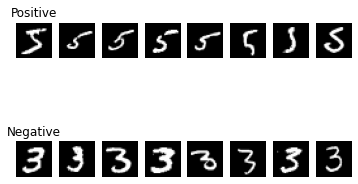

In [1]:
import os
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


def load_data1(path):
    # load all MNIST data
    fd = open(os.path.join(path, 'train-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    train_X_all = loaded[16:].reshape((60000, 28, 28, 1)).astype(np.float)
    fd = open(os.path.join(path, 'train-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    train_Y_all = loaded[8:].reshape(60000).astype(np.float)
    fd = open(os.path.join(path, 't10k-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    test_X_all = loaded[16:].reshape((10000, 28, 28, 1)).astype(np.float)
    fd = open(os.path.join(path, 't10k-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    test_Y_all = loaded[8:].reshape(10000).astype(np.float)

    #subsample data
    train_3_mask, train_5_mask = (train_Y_all == 3), (train_Y_all == 5) 
    test_3_mask, test_5_mask = (test_Y_all == 3), (test_Y_all == 5)
    train_Y_all[train_5_mask] = 1
    train_Y_all[train_3_mask] = 0
    test_Y_all[test_5_mask] = 1
    test_Y_all[test_3_mask] = 0
    train_mask = np.logical_or(train_5_mask, train_3_mask)
    test_mask = np.logical_or(test_5_mask, test_3_mask)
    train_X = train_X_all[train_mask]
    train_Y = train_Y_all[train_mask]
    test_X = test_X_all[test_mask]
    test_Y = test_Y_all[test_mask]

    #visualize data
    sample_num = 8
    for i in range(sample_num):
        plt_idx = i + 1
        plt.subplot(2, sample_num, plt_idx)
        plt.imshow(train_X_all[train_5_mask][i].reshape((28, 28)), cmap=plt.cm.gray)
        plt.axis('off')
        if i == 0:
            plt.title('Positive')

    for i in range(sample_num):
        plt_idx = sample_num + i + 1
        plt.subplot(2, sample_num, plt_idx)
        plt.imshow(train_X_all[train_3_mask][i].reshape((28, 28)), cmap=plt.cm.gray)
        plt.axis('off')
        if i == 0:
            plt.title('Negative')
    plt.show()
    # reshaple into rows and normalize
    train_X = train_X.reshape((train_X.shape[0], -1))
    test_X = test_X.reshape((test_X.shape[0], -1)) # reshape(shape[0],-1): reshape (a,b,c,d) into (a,b*c*d)
    mean_image = np.mean(train_X, axis=0) # axis=0: calculate mean of every column
    train_X = train_X - mean_image
    test_X = test_X - mean_image

    # add a bias column into X
    train_X = np.hstack([train_X, np.ones((train_X.shape[0], 1))])
    test_X = np.hstack([test_X, np.ones((test_X.shape[0], 1))]) # np.ones/zeros/eyes([row, col])
    return train_X, train_Y, test_X, test_Y


X_train, Y_train, X_test, Y_test = load_data1('./dataset/Assignment1/')

In [2]:
print("X_train shape is {}".format(X_train.shape))
print("Y_train shape is {}".format(Y_train.shape))
print("X_test shape is {}".format(X_test.shape))
print("Y_test shape is {}".format(Y_test.shape))

X_train shape is (11552, 785)
Y_train shape is (11552,)
X_test shape is (1902, 785)
Y_test shape is (1902,)


### 1.2逻辑回归模型
在这部分我们将会使用梯度下降算法训练逻辑回归模型。我们将会进行固定次数的迭代，在每个迭代过程中我们将计算数据样本的损失大小，以及对每个权重参数的梯度求导，并在此基础上进行梯度下降。算法的核心公式（此处包括损失函数和梯度下降，未包含正则项，在后面的实际要求中需要实现正则项）如下：

$$
L(f(x), y) = -y\log{f(x)}-(1-y)\log(1-f(x)), f(x) = \frac{e^{wx + b}}{1 + e^{wx + b}}
$$
$$
\begin{aligned}
\forall k, \frac{\partial}{\partial w_k} L(w,b) = \frac{1}{N}\sum_{i=1}^N (f(x^{(i)}) - y^{(i)}) x^{(i)}_k
\end{aligned}
$$

$$
\begin{aligned}
\frac{\partial}{\partial b} L(w,b)= \frac{1}{N}\sum_{i=1}^N (f(x^{(i)}) - y^{(i)})
\end{aligned}
$$


在这一部分中你需要完成以下内容：
1. train函数中权重$W$的更新
2. L1和L2两种正则化的损失函数及对应梯度的计算
3. predict函数中的预测类别的计算

#### Question1:
在下面利用线性模型进行逻辑回归的代码实现中，我们可以只需要权重矩阵 $W$ 而并不需要偏置项 $b$ ，为什么？（提示：之前的数据预处理过程中，除了将 $28 \times 28$ 的片“拍扁”并normalize以外，我们还做了哪步处理？）

#### Answer:上述预处理过程中，在归一化处理之后，代码通过向每个样本添加了一个恒等于1的特征来显式地引入了偏置项。由（np.hstack）函数完成的，在每个样本的特征向量末尾添加了一个值为1的维度。这样，当进行 `np.dot(X, self.W)` 运算时，权重矩阵 \(W\) 的最后一个元素实际上就扮演了偏置项 \(b\) 的角色。所以，每个样本的特征向量 \(X\) 现在包含了一个额外的维度，其值恒定为1。所以这就相当于偏置项，所以不需要偏置项了。

In [3]:

class LinearRegression1(object):
    def __init__(self):
        self.W = None
    
    def train(self, X, Y, learning_rate=1e-3, reg=1e-5, reg_type='L2', show_detail=True, num_iters=2000,
          batch_size=128):
        num_train, feat_dim = X.shape
        self.W = 0.001 * np.random.randn(feat_dim)
        loss_history = []
        if show_detail:
            print("train begin")
        for i in range(num_iters):
            batch_indices = np.random.choice(num_train, batch_size, replace=True)
            X_batch = X[batch_indices]
            Y_batch = Y[batch_indices]
            if reg_type == 'L1':
                loss, grad = self.l1_loss(X_batch, Y_batch, reg)
            else:
                loss, grad = self.l2_loss(X_batch, Y_batch, reg)
            loss_history.append(loss)
            
            if learning_rate < 0:
                learning_rate = learning_rate*((2000-i)/4000+0.5)
            ########################################
            # TODO: Update W
            
            self.W=self.W-grad*learning_rate

            ########################################
            if show_detail and i % 100 == 0:
                print("In iteration {}/{} , the loss is {}".format(i, num_iters, loss))
        return loss_history
    
    def Sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def func_f(self, X):
        return 1-self.Sigmoid(-np.dot(X,self.W))

    def calc(self, X, Y):
        func = self.func_f(X)
        loss = np.sum(-Y*np.log(func)-(1-Y)*np.log(1-func))
        grad = (np.dot((func-Y).reshape(1,-1), X)).T
        grad = np.array(grad).flatten()
        return loss / X.shape[0], grad / X.shape[0]

    def l1_loss(self, X, Y, reg):
        loss = 0
        grad = None
        
        ########################################
        # TODO: Calculate the loss and gradient
        loss, grad = self.calc(X, Y)
        l1_reg_loss = reg * np.sum(np.abs(self.W))
        loss += l1_reg_loss
        grad += reg * np.sign(self.W)
        ########################################
        
        return loss, grad
    
    def l2_loss(self, X, Y, reg):
        loss = 0
        grad = None

        ########################################
        # TODO: Calculate the loss and gradient
        loss, grad = self.calc(X, Y)  
        l2_reg_loss = reg * np.sum(self.W ** 2)
        loss += l2_reg_loss
        grad += 2* reg * self.W
        ########################################

        return loss, grad
    
    def predict(self, X, threshold=0.5):
        Y_pred = None
        
        ########################################
        # TODO: Predict the label of X with threshold
        # Hint: You may use func_f
        n_samples = X.shape[0]
        Y_pred = np.zeros(n_samples, dtype=int) 
        for i in range(n_samples):
            Y_pred[i] = 1 if self.func_f(X[i]) > threshold else 0
        ########################################
        
        return Y_pred

### 1.3 训练模型实例
在这一部分，你不需要完成任何代码，你可以通过这一部分验证你上面实现的LogisticRegression1的代码是否实现正确。

train begin
In iteration 0/2000 , the loss is 0.9500703644133897
In iteration 100/2000 , the loss is 0.2368603556753768
In iteration 200/2000 , the loss is 0.1275607941587
In iteration 300/2000 , the loss is 0.14696953755928371
In iteration 400/2000 , the loss is 0.19546118754215194
In iteration 500/2000 , the loss is 0.16077761893344675
In iteration 600/2000 , the loss is 0.13774952360704812
In iteration 700/2000 , the loss is 0.13068958558817673
In iteration 800/2000 , the loss is 0.09240261902000567
In iteration 900/2000 , the loss is 0.19332450963747283
In iteration 1000/2000 , the loss is 0.1796066784315178
In iteration 1100/2000 , the loss is 0.08618280977350558
In iteration 1200/2000 , the loss is 0.08440867670310565
In iteration 1300/2000 , the loss is 0.08146411494511363
In iteration 1400/2000 , the loss is 0.0874212941538489
In iteration 1500/2000 , the loss is 0.08986825401271975
In iteration 1600/2000 , the loss is 0.19820571772560838
In iteration 1700/2000 , the loss is 0.

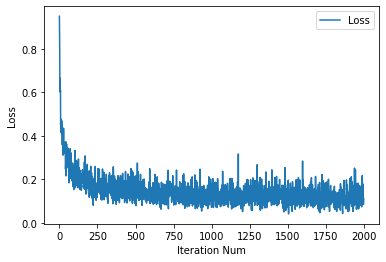

In [4]:
lr_param = 1.5e-6
reg_param = 0.01

model = LinearRegression1()
loss_history = model.train(X_train, Y_train, lr_param, reg_param, 'L2', True)
pred = model.predict(X_test)
acc = np.mean(pred == Y_test)
print("The Accuracy is {}\n".format(acc))
x = range(len(loss_history))
plt.plot(x, loss_history, label='Loss')
plt.legend()
plt.xlabel('Iteration Num')
plt.ylabel('Loss')
plt.show()
W = model.W

### 1.4 学习率和Loss函数、模型性能的关系
因为学习率和正则化参数都是超参数，在一般的训练过程中，我们没办法直接优化，所以我们一般会将训练集细分成训练集和验证集，然后通过模型在验证集上的表现选择一个最优的超参数，再将它对应的最优的模型应用到测试集中。
在这一部分你需要完成以下内容：
1. 在L1、L2两种正则化下尝试多种不同的学习率
2. 储存学习率对应的损失函数值到L1_loss和L2_loss中（我们对损失函数值进行了20步平均化处理）。
3. 储存学习率对应的**在验证集上**的正确率到L1_lr_val_acc和L2_lr_val_acc中

#### 注意：
你可以参考1.3的代码进行训练参数的设置。

因为已有代码中L1_loss，L1_lr_val_acc都是数组，在可视化的过程中我们需要学习率和它们相对应，比如learning_rates[0]对应的loss和validation accuracy应该储存在数组index为0的位置

#### 拓展：
在这个部分中采取的损失函数都是定值，如果你有时间的话，可以尝试根据迭代轮数改变学习率，并比较不变的学习率和变化的学习率对于模型性能的影响。

The Accuracy with learning rate 1e-10 and reg_type L1 is 0.6183470359151882

The Accuracy with learning rate 1e-10 and reg_type L2 is 0.35612289052358287

The Accuracy with learning rate 1e-09 and reg_type L1 is 0.5452185201211597

The Accuracy with learning rate 1e-09 and reg_type L2 is 0.43141497187364775

The Accuracy with learning rate 5e-09 and reg_type L1 is 0.5590653396797923

The Accuracy with learning rate 5e-09 and reg_type L2 is 0.613154478580701

The Accuracy with learning rate 1e-08 and reg_type L1 is 0.8013846819558632

The Accuracy with learning rate 1e-08 and reg_type L2 is 0.8013846819558632

The Accuracy with learning rate 5e-08 and reg_type L1 is 0.8848983124188663

The Accuracy with learning rate 5e-08 and reg_type L2 is 0.898745131977499

The Accuracy with learning rate 1e-07 and reg_type L1 is 0.9169190826482042

The Accuracy with learning rate 1e-07 and reg_type L2 is 0.9169190826482042

The Accuracy with learning rate 5e-07 and reg_type L1 is 0.9437472955430549


c:\Users\lupen\anaconda3\envs\gbzs\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in log
c:\Users\lupen\anaconda3\envs\gbzs\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in multiply


The Accuracy with learning rate 0.0001 and reg_type L1 is 0.9476417135439203

The Accuracy with learning rate 0.0001 and reg_type L2 is 0.950237992211164

The Accuracy with learning rate 0.001 and reg_type L1 is 0.9099956728688879

The Accuracy with learning rate 0.001 and reg_type L2 is 0.9485071397663349



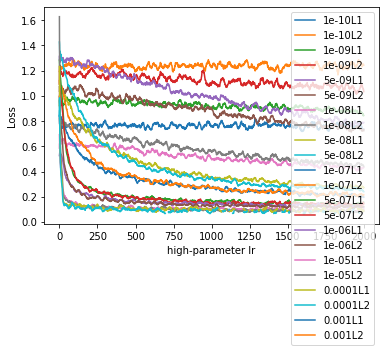

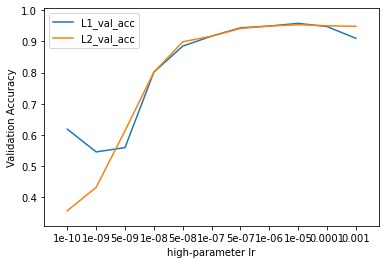

In [5]:
reg = 0.01
reg_types = ['L1', 'L2']
L1_loss = []
L2_loss = []
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2)
L1_lr_val_acc = []
L2_lr_val_acc = []

########################################
# TODO: train & test model with different learning rates

learning_rates = [
    1e-10, 
    1e-9, 
    5e-9,
    1e-8, 
    5e-8,
    1e-7, 
    5e-7,
    1e-6, 
    1e-5, 
    1e-4, 
    1e-3, 
]

for lr in learning_rates:
    for reg_type in reg_types:
        model = LinearRegression1()
        loss_history = model.train(X_train, Y_train, lr, reg, reg_type, False)
        pred = model.predict(X_val)
        acc = np.mean(pred == Y_val)
        if reg_type == 'L1':
            L1_loss.append(loss_history)
            L1_lr_val_acc.append(acc)
        else:
            L2_loss.append(loss_history)
            L2_lr_val_acc.append(acc)
        print("The Accuracy with learning rate {} and reg_type {} is {}\n".format(lr, reg_type, acc))


########################################
#visulize the relationship between lr and loss
for i, lr in enumerate(learning_rates):
    L1_loss_label = str(lr) + 'L1'
    L2_loss_label = str(lr) + 'L2'
    L1_loss_i = L1_loss[i]
    L2_loss_i = L2_loss[i]
    ave_L1_loss = np.zeros_like(L1_loss_i)
    ave_L2_loss = np.zeros_like(L2_loss_i)
    ave_step = 20
    for j in range(len(L1_loss_i)):
        if j < ave_step:
            ave_L1_loss[j] = np.mean(L1_loss_i[0: j + 1])
            ave_L2_loss[j] = np.mean(L2_loss_i[0: j + 1])
        else:
            ave_L1_loss[j] = np.mean(L1_loss_i[j - ave_step + 1: j + 1])    
            ave_L2_loss[j] = np.mean(L2_loss_i[j - ave_step + 1: j + 1])
    x = range(len(L1_loss_i))
    plt.plot(x, ave_L1_loss, label=L1_loss_label)
    plt.plot(x, ave_L2_loss, label=L2_loss_label)
    
plt.legend()
plt.xlabel('high-parameter lr')
plt.ylabel('Loss')
plt.show()

#visulize the relationship between lr and accuracy
x = range(len(learning_rates))
plt.plot(x, L1_lr_val_acc, label='L1_val_acc')
plt.plot(x, L2_lr_val_acc, label='L2_val_acc')
plt.xticks(x, learning_rates)
plt.margins(0.08)
plt.legend()
plt.xlabel('high-parameter lr')
plt.ylabel('Validation Accuracy')
plt.show()

#### Question2: 学习率和损失函数的变化、模型性能之间分别有什么关系？

#### Answer:基本上在梯度下降迭代次数一定的情况下，在1e-8的学习率下损失最小，在1e-5学习率下性能最好。模型性能随着学习率的增大先增大后减小，损失值随着学习率的增大先减小后增大

### 1.5 正则项与模型性能
在这一部分中，你需要完成以下内容：
1. 尝试多个正则化参数的值
2. 储存对应的在**验证集上**的正确率到L1_reg_val_acc和L2_reg_val_acc中
3. 通过验证集X_val和Y_val选择最优的正则化超参数，并储存最优正则化参数和对应模型

已有的代码会画出正则化参数和验证集上正确率的关系图，并计算最优的模型在测试集上的正确率。

#### 注意：
和上面学习率一样，L1_reg_val_acc的存储也需要和正则化参数值对应。

The Accuracy with reg 1e-07 and reg_type L1 is 0.961060032449973

The Accuracy with reg 1e-07 and reg_type L2 is 0.9594375338020552

The Accuracy with reg 5e-07 and reg_type L1 is 0.9594375338020552

The Accuracy with reg 5e-07 and reg_type L2 is 0.9594375338020552

The Accuracy with reg 1e-06 and reg_type L1 is 0.9605191995673337

The Accuracy with reg 1e-06 and reg_type L2 is 0.9594375338020552

The Accuracy with reg 5e-06 and reg_type L1 is 0.9594375338020552

The Accuracy with reg 5e-06 and reg_type L2 is 0.9588967009194159

The Accuracy with reg 1e-05 and reg_type L1 is 0.9616008653326122

The Accuracy with reg 1e-05 and reg_type L2 is 0.9599783666846944

The Accuracy with reg 5e-05 and reg_type L1 is 0.9621416982152515

The Accuracy with reg 5e-05 and reg_type L2 is 0.9599783666846944

The Accuracy with reg 0.0001 and reg_type L1 is 0.9605191995673337

The Accuracy with reg 0.0001 and reg_type L2 is 0.9621416982152515

The Accuracy with reg 0.0005 and reg_type L1 is 0.95835586803

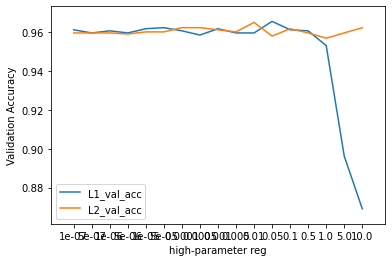

The Accuracy with L1 regularization parameter 0.05 is 0.9589905362776026

The Accuracy with L2 regularization parameter 0.01 is 0.9600420609884333



In [6]:
learning_rate = 1.5e-6
reg_types = ['L1', 'L2']
L1_reg_val_acc = []
L2_reg_val_acc = []
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2)
best_L1_model = None
best_L2_model = None
best_L1_reg = 0
best_L2_reg = 0
best_L1_acc = 0
best_L2_acc = 0

########################################
# TODO: train & test model with different regularization 
regs = [
    1e-7, 5e-7,
    1e-6, 5e-6,
    1e-5, 5e-5,
    1e-4, 5e-4,
    1e-3, 5e-3,
    1e-2, 5e-2,
    1e-1, 5e-1,
    1e0,   
    5e0,   
    1e1    
]
for reg in regs:
    for reg_type in reg_types:
        model = LinearRegression1()
        loss_history = model.train(X_train, Y_train, learning_rate, reg, reg_type, False)
        pred = model.predict(X_val)
        acc = np.mean(pred == Y_val)
        if reg_type == 'L1':
            L1_reg_val_acc.append(acc)
            if acc > best_L1_acc:
                best_L1_acc = acc
                best_L1_model = model
                best_L1_reg = reg
        else:
            L2_reg_val_acc.append(acc)
            if acc > best_L2_acc:
                best_L2_acc = acc
                best_L2_model = model
                best_L2_reg = reg
        print("The Accuracy with reg {} and reg_type {} is {}\n".format(reg, reg_type, acc))
    # newmodelL1=LinearRegression1()
    # newmodelL2=LinearRegression1()  
    # L1_loss = newmodelL1.train(X_train, Y_train, learning_rate, reg, 'L1', False)
    # pred = newmodelL1.predict(X_val)
    # L1_val_acc = np.mean(pred == Y_val)
    # L1_reg_val_acc.append(L1_val_acc)
    # if L1_val_acc > best_L1_acc:
    #     best_L1_acc = L1_val_acc
    #     best_L1_model = newmodelL1
    #     best_L1_reg = reg
    # L2_loss = newmodelL2.train(X_train, Y_train, learning_rate, reg, 'L2', False)
    # pred = newmodelL2.predict(X_val)
    # L2_val_acc = np.mean(pred == Y_val)
    # L2_reg_val_acc.append(L2_val_acc)
    # if L2_val_acc > best_L2_acc:
    #     best_L2_acc = L2_val_acc
    #     best_L2_model = newmodelL2
    #     best_L2_reg = reg

########################################

#visulize the relation of regularization parameter and validation accuracy
x = range(len(regs))
plt.plot(x, L1_reg_val_acc, label='L1_val_acc')
plt.plot(x, L2_reg_val_acc, label='L2_val_acc')
plt.xticks(x, regs)
plt.margins(0.08)
plt.legend()
plt.xlabel('high-parameter reg')
plt.ylabel('Validation Accuracy')
plt.show()

#Compute the performance of best model on the test set
L1_pred = best_L1_model.predict(X_test)
L1_acc = np.mean(L1_pred == Y_test)
print("The Accuracy with L1 regularization parameter {} is {}\n".format(best_L1_reg, L1_acc))
L2_pred = best_L2_model.predict(X_test)
L2_acc = np.mean(L2_pred == Y_test)
print("The Accuracy with L2 regularization parameter {} is {}\n".format(best_L2_reg, L2_acc))

## 作业二、多分类逻辑回归


### 2.1 加载数据集

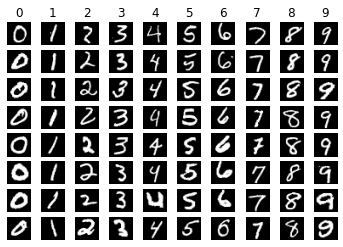

In [7]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


def load_data2(path):
    # load all MNIST data
    fd = open(os.path.join(path, 'train-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    train_X = loaded[16:].reshape((60000, 28, 28, 1)).astype(np.float)
    fd = open(os.path.join(path, 'train-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    train_Y = loaded[8:].reshape(60000).astype(np.float)
    fd = open(os.path.join(path, 't10k-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    test_X = loaded[16:].reshape((10000, 28, 28, 1)).astype(np.float)
    fd = open(os.path.join(path, 't10k-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd, dtype=np.uint8)
    test_Y = loaded[8:].reshape(10000).astype(np.float)

    #visualize data
    sample_num = 8
    num_classes = 10
    for y in range(num_classes):
        idxs = np.flatnonzero(train_Y == y)
        idxs = np.random.choice(idxs, sample_num, replace=False)
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + y + 1
            plt.subplot(sample_num, num_classes, plt_idx)
            plt.imshow(train_X[idx, :, :, :].reshape((28,28)),cmap=plt.cm.gray)
            plt.axis('off')
            if i == 0:
                plt.title(y)
    plt.show()

    # reshaple into rows and normaliza
    train_X = train_X.reshape((train_X.shape[0], -1))
    test_X = test_X.reshape((test_X.shape[0], -1))
    mean_image = np.mean(train_X, axis=0)
    train_X = train_X - mean_image
    test_X = test_X - mean_image

    # add a bias columu into X
    train_X = np.hstack([train_X, np.ones((train_X.shape[0], 1))])
    test_X = np.hstack([test_X, np.ones((test_X.shape[0], 1))])
    train_Y = train_Y.astype(np.int32)
    test_Y = test_Y.astype(np.int32)
    return train_X, train_Y, test_X, test_Y


X_train, Y_train, X_test, Y_test = load_data2('./dataset/Assignment1/')

In [8]:
print("X_train shape is {}".format(X_train.shape))
print("Y_train shape is {}".format(Y_train.shape))
print("X_test shape is {}".format(X_test.shape))
print("Y_test shape is {}".format(Y_test.shape))

X_train shape is (60000, 785)
Y_train shape is (60000,)
X_test shape is (10000, 785)
Y_test shape is (10000,)


### 2.2逻辑回归模型
在这一部分中你需要完成与二分类逻辑回归相同的任务。

In [9]:
 from scipy.special import softmax

In [10]:
class LinearRegression2(object):
    def __init__(self):
        self.W = None
    def train(self, X, Y, learning_rate=1e-3, reg=1e-5, reg_type='L2', show_detail=True, num_iters=2000,
              batch_size=128):
        num_train, feat_dim = X.shape
        num_classes = 10
        self.W = 0.001 * np.random.randn(feat_dim, num_classes)
        loss_history = []
        if show_detail:
            print("train begin")
        for i in range(num_iters):
            batch_indices = np.random.choice(num_train, batch_size, replace=True)
            X_batch = X[batch_indices]
            Y_batch = Y[batch_indices]
            if reg_type == 'L1':
                loss, grad = self.l1_loss(X_batch, Y_batch, reg)
            else:
                loss, grad = self.l2_loss(X_batch, Y_batch, reg)
            loss_history.append(loss)
            
            ########################################
            # TODO: update W
            self.W=self.W-grad*learning_rate
            
            ########################################
       
            if show_detail and i % 100 == 0:
                print("In iteration {}/{} , the loss is {}".format(i, num_iters, loss))
        return loss_history

    def calc(self, X, Y):
        num_train, feat_dim = X.shape
        class_dim = self.W.shape[1]
        loss = 0
        grad = np.zeros([class_dim, feat_dim])
        #soft = softmax(np.dot(X, self.W))
        for i in range(num_train):
            soft = softmax(np.dot(X[i], self.W))
            loss += -np.log(soft[Y[i]])
            for j in range(class_dim):
                prob = soft[j]
                if j == Y[i]:
                    prob -= 1
                grad[j] += X[i] * prob
        grad = grad.T
        return loss / X.shape[0], grad / X.shape[0]

    def l1_loss(self,X, Y, reg):
        loss = 0
        grad = None
    
        ########################################
        # TODO: Calculate the loss and gradient
        loss, grad = self.calc(X, Y)
        l1_reg_loss = reg * np.sum(np.abs(self.W))
        loss += l1_reg_loss
        grad += reg * np.sign(self.W)
        ########################################
    
        return loss, grad
            
    
    def l2_loss(self, X, Y, reg):
        loss = 0
        grad = None
        
        ########################################
        # TODO: Calculate the loss and gradient
        loss, grad = self.calc(X, Y)  
        l2_reg_loss = reg * np.sum(self.W ** 2)
        loss += l2_reg_loss
        grad += 2*reg * self.W
        ########################################
        
        return loss, grad

    def predict(self, X):
        Y_pred = None

        ########################################
        # TODO: Predict the label of X
        n_samples = X.shape[0]
        Y_pred = np.zeros(n_samples, dtype=int) 
        for i in range(n_samples):
            Y_pred[i] = np.argmax(softmax(np.dot(X[i], self.W)))
        
        ########################################
    
        return Y_pred
        
def divide(a, b):
    return a / b

### 2.3 训练模型样例
在这一部分，你不需要完成任何代码，你可以通过这一部分验证你上面实现的LogisticRegression2的代码是否实现正确。

train begin
In iteration 0/2000 , the loss is 3.6887579368270274
In iteration 100/2000 , the loss is 1.0945216404597606
In iteration 200/2000 , the loss is 0.769204542221858
In iteration 300/2000 , the loss is 0.5227653648524128
In iteration 400/2000 , the loss is 0.6343161582834549
In iteration 500/2000 , the loss is 0.5911324264071228
In iteration 600/2000 , the loss is 0.358711271406962
In iteration 700/2000 , the loss is 0.375686919140315
In iteration 800/2000 , the loss is 0.6144207024153452
In iteration 900/2000 , the loss is 0.5345967987600939
In iteration 1000/2000 , the loss is 0.35494137393011593
In iteration 1100/2000 , the loss is 0.6324217474209108
In iteration 1200/2000 , the loss is 0.3406784896379038
In iteration 1300/2000 , the loss is 0.525276674148105
In iteration 1400/2000 , the loss is 0.36420032373231026
In iteration 1500/2000 , the loss is 0.4260996484349332
In iteration 1600/2000 , the loss is 0.43202574345871253
In iteration 1700/2000 , the loss is 0.2175795918

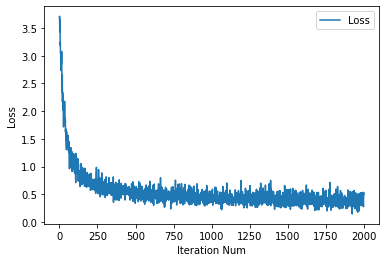

In [11]:
lr_param = 1e-6
reg_param = 0.01
model = LinearRegression2()
loss_history = model.train(X_train, Y_train, lr_param, reg_param, 'L2')
pred = model.predict(X_test)
acc = np.mean(pred == Y_test)
print("The Accuracy is {}\n".format(acc))
x = range(len(loss_history))
plt.plot(x, loss_history, label='Loss')
plt.legend()
plt.xlabel('Iteration Num')
plt.ylabel('Loss')
plt.show()

### 2.4 学习率与损失函数、模型性能的关系
因为学习率和正则化参数都是超参数，在一般的训练过程中，我们没办法直接优化，所以我们一般会将训练集细分成训练集和验证集，然后通过模型在验证集上的表现选择一个最优的超参数，再将它对应的最优的模型应用到测试集中。
在这一部分你需要完成以下内容：
1. 尝试多种不同的学习率
2. 储存学习率对应的损失函数值到L1_loss和L2_loss中（我们对损失函数值进行了20步平均化处理）。
3. 储存学习率对应的**在验证集上**的正确率到L1_lr_val_acc和L2_lr_val_acc中

#### 注意：
因为已有代码中L1_loss，L1_lr_val_acc都是数组，在可视化的过程中我们需要学习率和它们相对应，比如learning_rates[0]对应的loss和validation accuracy应该储存在数组index为0的位置

#### 拓展：
在这个部分中采取的损失函数都是定值，如果你有时间的话，可以尝试根据迭代轮数改变学习率，并比较不变的学习率和变化的学习率对于模型性能的影响。

The Accuracy with learning rate 1e-10 and reg_type L1 is 0.15233333333333332

The Accuracy with learning rate 1e-10 and reg_type L2 is 0.06016666666666667

The Accuracy with learning rate 1e-09 and reg_type L1 is 0.15875

The Accuracy with learning rate 1e-09 and reg_type L2 is 0.11875

The Accuracy with learning rate 5e-09 and reg_type L1 is 0.26175

The Accuracy with learning rate 5e-09 and reg_type L2 is 0.18616666666666667

The Accuracy with learning rate 1e-08 and reg_type L1 is 0.2965

The Accuracy with learning rate 1e-08 and reg_type L2 is 0.31875

The Accuracy with learning rate 5e-08 and reg_type L1 is 0.6614166666666667

The Accuracy with learning rate 5e-08 and reg_type L2 is 0.679

The Accuracy with learning rate 1e-07 and reg_type L1 is 0.77425

The Accuracy with learning rate 1e-07 and reg_type L2 is 0.7678333333333334

The Accuracy with learning rate 5e-07 and reg_type L1 is 0.8688333333333333

The Accuracy with learning rate 5e-07 and reg_type L2 is 0.8648333333333333


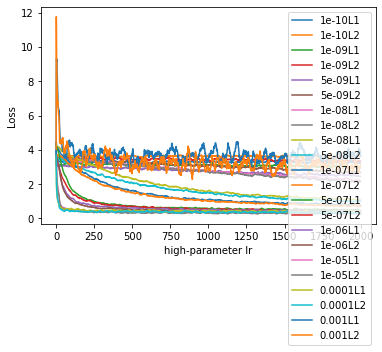

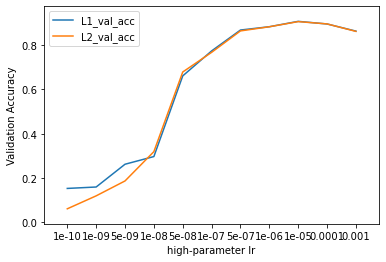

In [12]:
reg = 0.01
reg_types = ['L1', 'L2']
L1_loss = []
L2_loss = []
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2)
L1_lr_val_acc = []
L2_lr_val_acc = []

########################################
# TODO: train & test model with different learning rate
learning_rates = [
    1e-10, 
    1e-9, 
    5e-9,
    1e-8, 
    5e-8,
    1e-7, 
    5e-7,
    1e-6, 
    1e-5, 
    1e-4, 
    1e-3, 
]

for lr in learning_rates:
    for reg_type in reg_types:
        model = LinearRegression2()
        loss_history = model.train(X_train, Y_train, lr, reg, reg_type, False)
        pred = model.predict(X_val)
        acc = np.mean(pred == Y_val)
        if reg_type == 'L1':
            L1_loss.append(loss_history)
            L1_lr_val_acc.append(acc)
        else:
            L2_loss.append(loss_history)
            L2_lr_val_acc.append(acc)
        print("The Accuracy with learning rate {} and reg_type {} is {}\n".format(lr, reg_type, acc))



########################################

#visulize the relationship between lr and loss
for i, lr in enumerate(learning_rates):
    L1_loss_label = str(lr) + 'L1'
    L2_loss_label = str(lr) + 'L2'
    L1_loss_i = L1_loss[i]
    L2_loss_i = L2_loss[i]
    ave_L1_loss = np.zeros_like(L1_loss_i)
    ave_L2_loss = np.zeros_like(L2_loss_i)
    ave_step = 20
    for j in range(len(L1_loss_i)):
        if j < ave_step:
            ave_L1_loss[j] = np.mean(L1_loss_i[0: j + 1])
            ave_L2_loss[j] = np.mean(L2_loss_i[0: j + 1])
        else:
            ave_L1_loss[j] = np.mean(L1_loss_i[j - ave_step + 1: j + 1])    
            ave_L2_loss[j] = np.mean(L2_loss_i[j - ave_step + 1: j + 1])
    x = range(len(L1_loss_i))
    plt.plot(x, ave_L1_loss, label=L1_loss_label)
    plt.plot(x, ave_L2_loss, label=L2_loss_label)
    
plt.legend()
plt.xlabel('high-parameter lr')
plt.ylabel('Loss')
plt.show()

#visulize the relationship between lr and accuracy
x = range(len(learning_rates))
plt.plot(x, L1_lr_val_acc, label='L1_val_acc')
plt.plot(x, L2_lr_val_acc, label='L2_val_acc')
plt.xticks(x, learning_rates)
plt.margins(0.08)
plt.legend()
plt.xlabel('high-parameter lr')
plt.ylabel('Validation Accuracy')
plt.show()

### 2.5 正则项与模型性能
在这一部分中，你需要完成以下内容：
1. 尝试多个正则化参数的值
2. 储存对应的在**验证集上**的正确率到L1_reg_val_acc和L2_reg_val_acc中
3. 通过验证集X_val和Y_val选择最优的正则化超参数，并储存最优正则化参数和对应模型

已有的代码会画出正则化参数和验证集上正确率的关系图，并计算最优的模型在测试集上的正确率。

#### 注意：
和上面学习率一样，L1_reg_val_acc的存储也需要和正则化参数值对应。

The Accuracy with reg 1e-07 and reg_type L1 is 0.9110416666666666

The Accuracy with reg 1e-07 and reg_type L2 is 0.9115625

The Accuracy with reg 5e-07 and reg_type L1 is 0.9123958333333333

The Accuracy with reg 5e-07 and reg_type L2 is 0.9091666666666667

The Accuracy with reg 1e-06 and reg_type L1 is 0.91

The Accuracy with reg 1e-06 and reg_type L2 is 0.9104166666666667

The Accuracy with reg 5e-06 and reg_type L1 is 0.9113541666666667

The Accuracy with reg 5e-06 and reg_type L2 is 0.9038541666666666

The Accuracy with reg 1e-05 and reg_type L1 is 0.9089583333333333

The Accuracy with reg 1e-05 and reg_type L2 is 0.9132291666666666

The Accuracy with reg 5e-05 and reg_type L1 is 0.91

The Accuracy with reg 5e-05 and reg_type L2 is 0.9091666666666667

The Accuracy with reg 0.0001 and reg_type L1 is 0.910625

The Accuracy with reg 0.0001 and reg_type L2 is 0.9083333333333333

The Accuracy with reg 0.0005 and reg_type L1 is 0.9092708333333334

The Accuracy with reg 0.0005 and reg_ty

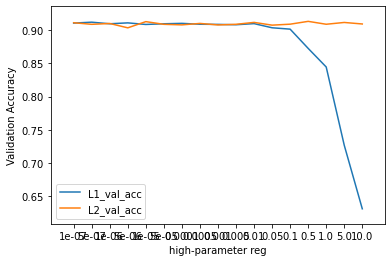

The Accuracy with L1 regularization parameter 5e-07 is 0.9135

The Accuracy with L1 regularization parameter 0.5 is 0.9155



In [13]:
learning_rate = 1.5e-5 #initial 1.5e-6
reg_types = ['L1', 'L2']
L1_reg_val_acc = []
L2_reg_val_acc = []
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2)
best_L1_model = None
best_L2_model = None
best_L1_reg = 0
best_L2_reg = 0
best_L1_acc = 0
best_L2_acc = 0

########################################
# TODO: train & test model with different regularization 
regs = [
    1e-7, 5e-7,
    1e-6, 5e-6,
    1e-5, 5e-5,
    1e-4, 5e-4,
    1e-3, 5e-3,
    1e-2, 5e-2,
    1e-1, 5e-1,
    1e0,   
    5e0,   
    1e1    
]
for reg in regs:
    for reg_type in reg_types:
        model = LinearRegression2()
        loss_history = model.train(X_train, Y_train, learning_rate, reg, reg_type, False)
        pred = model.predict(X_val)
        acc = np.mean(pred == Y_val)
        if reg_type == 'L1':
            L1_reg_val_acc.append(acc)
            if acc > best_L1_acc:
                best_L1_acc = acc
                best_L1_model = model
                best_L1_reg = reg
        else:
            L2_reg_val_acc.append(acc)
            if acc > best_L2_acc:
                best_L2_acc = acc
                best_L2_model = model
                best_L2_reg = reg
        print("The Accuracy with reg {} and reg_type {} is {}\n".format(reg, reg_type, acc))
    # newmodelL1=LinearRegression1()
    # newmodelL2=LinearRegression1()  
    # L1_loss = newmodelL1.train(X_train, Y_train, learning_rate, reg, 'L1', False)
    # pred = newmodelL1.predict(X_val)
    # L1_val_acc = np.mean(pred == Y_val)
    # L1_reg_val_acc.append(L1_val_acc)
    # if L1_val_acc > best_L1_acc:
    #     best_L1_acc = L1_val_acc
    #     best_L1_model = newmodelL1
    #     best_L1_reg = reg
    # L2_loss = newmodelL2.train(X_train, Y_train, learning_rate, reg, 'L2', False)
    # pred = newmodelL2.predict(X_val)
    # L2_val_acc = np.mean(pred == Y_val)
    # L2_reg_val_acc.append(L2_val_acc)
    # if L2_val_acc > best_L2_acc:
    #     best_L2_acc = L2_val_acc
    #     best_L2_model = newmodelL2
    #     best_L2_reg = reg

########################################

#visuliza the relation of regularization parameter and validation accuracy
x = range(len(regs))
plt.plot(x, L1_reg_val_acc, label='L1_val_acc')
plt.plot(x, L2_reg_val_acc, label='L2_val_acc')
plt.xticks(x, regs)
plt.margins(0.08)
plt.legend()
plt.xlabel('high-parameter reg')
plt.ylabel('Validation Accuracy')
plt.show()

#Compute the performance of best model on the test set
L1_pred = best_L1_model.predict(X_test)
L1_acc = np.mean(L1_pred == Y_test)
print("The Accuracy with L1 regularization parameter {} is {}\n".format(best_L1_reg, L1_acc))
L2_pred = best_L2_model.predict(X_test)
L2_acc = np.mean(L2_pred == Y_test)
print("The Accuracy with L1 regularization parameter {} is {}\n".format(best_L2_reg, L2_acc))

#### Question3: 对于上面的多分类逻辑回归模型，你觉得它的权重矩阵数值上会呈现出什么样子？你可以通过下面提供的可视化方法观察权重矩阵。

#### Answer:矩阵数值上每一列对应于一个类别，对于与识别特定数字类别高度相关的像素点，其权重值可能较大；而对于与类别判定无关或者对所有类别几乎都同样重要的像素点，其权重值可能接近于零或较小。即权重矩阵对应权重较大的地方即是对应数字的轮廓。


In [14]:
lr_param = 1e-6
reg_param = 1000
model = LinearRegression2()
loss_history = model.train(X_train, Y_train, lr_param, reg_param, 'L2')
pred = model.predict(X_test)
acc = np.mean(pred == Y_test)
print("The Accuracy is {}\n".format(acc))

train begin
In iteration 0/2000 , the loss is 11.389724839308744
In iteration 100/2000 , the loss is 6.14592691213828
In iteration 200/2000 , the loss is 4.170396080664487
In iteration 300/2000 , the loss is 2.914754530626265
In iteration 400/2000 , the loss is 2.182832858118508
In iteration 500/2000 , the loss is 1.7458662234709594
In iteration 600/2000 , the loss is 1.426928357621049
In iteration 700/2000 , the loss is 1.130677500639127
In iteration 800/2000 , the loss is 1.0810889472097256
In iteration 900/2000 , the loss is 1.051534507614402
In iteration 1000/2000 , the loss is 0.8949754452681917
In iteration 1100/2000 , the loss is 0.8450053249997145
In iteration 1200/2000 , the loss is 0.8104413108863867
In iteration 1300/2000 , the loss is 0.8143076962531908
In iteration 1400/2000 , the loss is 0.7713277514164261
In iteration 1500/2000 , the loss is 0.7431089518075379
In iteration 1600/2000 , the loss is 0.8230553854358715
In iteration 1700/2000 , the loss is 0.8209711891875817


Weight matrix of digit  0


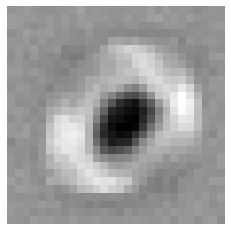

Weight matrix of digit  1


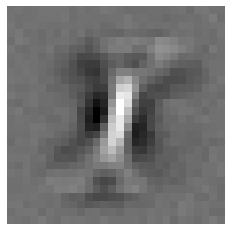

Weight matrix of digit  2


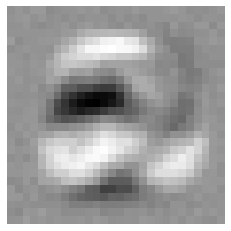

Weight matrix of digit  3


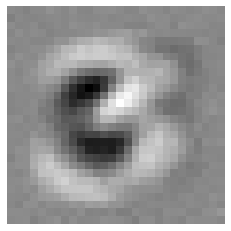

Weight matrix of digit  4


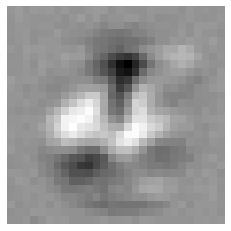

Weight matrix of digit  5


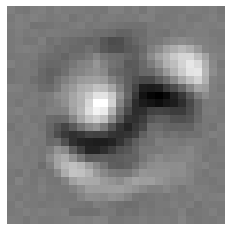

Weight matrix of digit  6


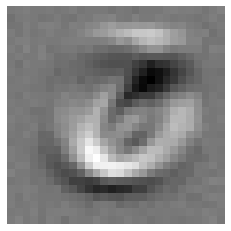

Weight matrix of digit  7


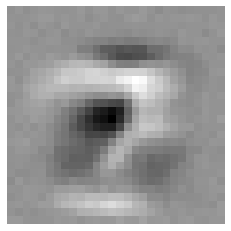

Weight matrix of digit  8


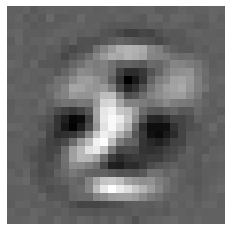

Weight matrix of digit  9


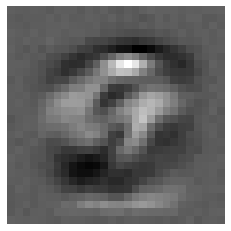

In [15]:
for i in range(10):
    pic = np.delete((model.W.T)[i], -1)
    pic = pic.reshape(28, -1)
    pic_min = np.min(pic)
    pic_max = np.max(pic)
    pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic)) * 255.0
    print("Weight matrix of digit ", i)
    plt.imshow(pic, cmap = plt.cm.gray)
    plt.axis('off')
    plt.show()